In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.cm as cm
from ase.io import read
import copy
import matplotlib.patches as patches

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy
from timeit import default_timer as de_time
from pymcaspec import specfile
from matplotlib.patches import Rectangle, FancyBboxPatch

#plt.rcParams['text.usetex'] = True
mpl.rc('lines', markersize=3)
colors = [f'C{i}' for i in range(10)]
font = {'size' : 7}
matplotlib.rc('font', **font)

In [2]:
# Helper functions
def load_var(filename, form='pickle'):
    """
    Load the variable.
    Example
    -------
    >>> data = load_var('data.pkl')
    """
    if form=='numpy':
        data = np.load(filename)
    elif form=='pickle':
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        file.close
    return data

def mybin(x,y,yerr, binsize):
    new_x = []
    new_y = []
    new_yerr = []
    index = len(x)
    for i in range(0,index, binsize): #n is index, i is value      
        new_x.append(np.mean(x[i:i+binsize]))
        new_y.append(np.mean(y[i:i+binsize]))
        new_yerr.append(np.sqrt(np.mean(yerr[i:i+binsize]**2)))  
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_yerr = np.array(new_yerr)
    
    return new_x, new_y, new_yerr

def rixsDataReader(data_folder, scan, spectrum_name='SPC', xshift = 0, interp=False, x_ref=None, scale = 1, norm=False, 
                   monitor_name='Mirror current / 1e6'): 
    f = specfile(data_folder)
    s = f[scan]
    x = -s['Energy (eV)'][::-1]
    y = s[spectrum_name][::-1]
    
    x = x + xshift
    yerr = np.sqrt(y)

    if interp and isinstance(x_ref, (list, np.ndarray)):
        y = np.interp(x_ref,x,y)
        yerr = np.sqrt(y)
        x = x_ref
    
    if norm:
        norm_factor = s[monitor_name][::-1]
        y = y / norm_factor
        yerr = yerr / norm_factor
        
    y = y * scale
    yerr = yerr * scale
    return x, y, yerr



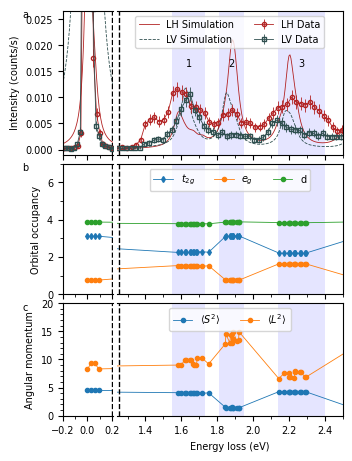

In [3]:
import pickle
fname = './edrixs/AIM_RIXS_analysis.pickle'

with open(fname, 'rb') as f:
    x = pickle.load(f)

# Make the figure and subplots
fig = plt.figure(figsize=((3+3/8), 4.5))
hh = 0.32
hh1 = 0.25
dh = 0.02

dd1 = 0.02
ax2a = fig.add_axes([0.14, 0.04+2*hh1+3*dh+dd1+0.05,0.15,hh])
ax4a = fig.add_axes([0.14, hh1+2*dh+dd1+0.05,0.15,hh1+0.04])
ax5a = fig.add_axes([0.14, dh+dd1+0.05, 0.15,hh1])

ax2 = fig.add_axes([0.3, 0.04+2*hh1+3*dh+dd1+0.05,0.67,hh])
ax4 = fig.add_axes([0.3, hh1+2*dh+dd1+0.05,0.67,hh1+0.04])
ax5 = fig.add_axes([0.3, dh+dd1+0.05, 0.67,hh1])

# Plot RIXS simulation in the top panel 
rixs_sim = x
ax2.plot(rixs_sim['eloss'], rixs_sim['rixs_lh'][0][0]/20, color='firebrick', label='LH Simulation', linewidth=0.6)
ax2.plot(rixs_sim['eloss'], rixs_sim['rixs_lv'][0][0]/20, color='darkslategray', label='LV Simulation', linewidth=0.6, ls='dashed')
ax2a.plot(rixs_sim['eloss'], rixs_sim['rixs_lh'][0][0]/20, color='firebrick', label='LH Simulation', linewidth=0.6)
ax2a.plot(rixs_sim['eloss'], rixs_sim['rixs_lv'][0][0]/20, color='darkslategray', label='LV Simulation', linewidth=0.6, ls='dashed')

# Plot the RIXS experimental data in the second panel
f = specfile('./Online_analysis_20220913_CrSBr_5_00_dir.spec')
datafolder = './Online_analysis_20220913_CrSBr_5_00_dir.spec'
# LH, Ein=577.4 eV, zero shift adjusted by hand
scan = 88
s = f[scan]
x0,y0,yerr = rixsDataReader(datafolder, scan, xshift=-0.022 , norm=True)  
x0,y0,yerr = mybin(x0, y0, yerr, 8)
norm = np.average(s['Mirror current / 1e6'][::-1])/5400
ax2.errorbar(x0, y0*norm, yerr*norm, color='firebrick', label='LH Data', marker='o', mfc='None', linewidth=0.6)
ax2a.errorbar(x0, y0*norm, yerr*norm, color='firebrick', label='LH Data', marker='o', mfc='None', linewidth=0.6)

# LV, Ein=577.4 eV, zero shift adjusted by hand
scan = 99
s = f[scan]
x0,y0,yerr = rixsDataReader(datafolder, scan, xshift=-0.017 , norm=True)  
x0,y0,yerr = mybin(x0, y0, yerr, 8)
norm = np.average(s['Mirror current / 1e6'][::-1])/5400
ax2.errorbar(x0, y0*norm, yerr*norm, color='darkslategray', label='LV Data', marker='s', mfc='None', linewidth=0.6)
ax2a.errorbar(x0, y0*norm, yerr*norm, color='darkslategray', label='LV Data', marker='s', mfc='None', linewidth=0.6)

ax2a.set_ylim(-0.001,1.2/45)
ax2a.set_xlim(-0.2,0.21)

ax2.set_ylim(-0.001,1.2/45)
ax2.set_xlim(1.24,2.5)
ax2.legend(loc='upper center', ncols=2)

# Plot the orbital occupancies in the third panel
evals = x['rixs_ana_results']['evals']
t2g = x['rixs_ana_results']['d_t2g']
eg = x['rixs_ana_results']['d_eg']

ax4.plot(evals, t2g, marker='d',  label=r'$t_{2g}$', linewidth=0.6)
ax4.plot(evals, eg, marker='o',  label=r'$e_g$', linewidth=0.6)
ax4.plot(evals, t2g+eg, marker='o',  label='d', linewidth=0.6)

ax4a.plot(evals, t2g, marker='d',  label=r'$t_{2g}$', linewidth=0.6)
ax4a.plot(evals, eg, marker='o',  label=r'$e_g$', linewidth=0.6)
ax4a.plot(evals, t2g+eg, marker='o',  label='d', linewidth=0.6)

ax4.legend(loc='upper center', ncols=3)
ax4.set_ylim(0, 7)
ax4.set_xlim(1.24,2.5)
ax4a.set_ylim(0, 7)
ax4a.set_xlim(-0.2,0.21)

# Plot the total spin in the fourth panel
L2 = x['rixs_ana_results']['L2_Cr_val']
S2 = x['rixs_ana_results']['S2_Cr_val']

ax5.plot(evals, S2, label=r'$\langle S^2 \rangle$', marker='o', linewidth=0.6)
ax5.plot(evals, L2, label=r'$\langle L^2 \rangle$', marker='o', linewidth=0.6)

ax5a.plot(evals, S2, label=r'$\langle S^2 \rangle$', marker='o', linewidth=0.6)
ax5a.plot(evals, L2, label=r'$\langle L^2 \rangle$', marker='o', linewidth=0.6)

ax5.legend()
ax5.legend(loc='upper center', ncols=2)

ax5.set_ylim(0, 20)
ax5.set_xlim(1.24,2.5)
ax5a.set_ylim(0, 20)
ax5a.set_xlim(-0.2,0.21)

# Label the axes
ax2.tick_params(labelbottom = False, left=False, labelleft=False ) 
ax4.tick_params(labelbottom = False, left=False, labelleft=False ) 
ax5.tick_params( left=False, labelleft=False ) 

ax2a.tick_params(labelbottom = False ) 
ax4a.tick_params(labelbottom = False ) 

ax2a.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax4a.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5a.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax2a.set_ylabel('Intensity (counts/s)')
ax4a.set_ylabel('Orbital occupancy')
ax5a.set_ylabel('Angular momentum')
ax5.set_xlabel('Energy loss (eV)')

ax2a.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))
ax4a.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax5a.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax4.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax5.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax2a.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax4a.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax5a.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax2a.axvline(x=0.2, ls='--', color='k', linewidth=1)
ax4a.axvline(x=0.2, ls='--', color='k', linewidth=1)
ax5a.axvline(x=0.2, ls='--', color='k', linewidth=1)

ax2.axvline(x=1.25, ls='--', color='k', linewidth=1)
ax4.axvline(x=1.25, ls='--', color='k', linewidth=1)
ax5.axvline(x=1.25, ls='--', color='k', linewidth=1)

 
for ax in [ax2, ax4, ax5]:
    ax.fill_betweenx([-10, 30], 1.55, 1.73, color='blue', alpha=0.1, edgecolor='None')
    ax.fill_betweenx([-10, 30], 1.81, 1.95, color='blue', alpha=0.1, edgecolor='None')
    ax.fill_betweenx([-10, 30], 2.14, 2.4, color='blue', alpha=0.1, edgecolor='None')


ax2.text(1.625, 0.016, '1')
ax2.text(1.863, 0.016, '2')
ax2.text(2.25, 0.016, '3')

fig.text(0.02, -0.015+hh+2*hh1+3*dh+dd1+0.09, 'a', fontsize=7)
fig.text(0.02, -0.015+2*hh1+2*dh+dd1+0.09, 'b', fontsize=7)
fig.text(0.02, -0.015+hh1+1*dh+dd1+0.05, 'c', fontsize=7)

plt.show()